In [1]:
!unzip -qq -n "/content/drive/MyDrive/Datasets/Image Classification/small_animals.zip" -d "/content/sample_data/data"

In [2]:
%cd "/content/drive/MyDrive/Image Classification/CLS - tensorflow 2"

/content/drive/MyDrive/Image Classification/CLS - tensorflow 2


In [201]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle

from data_utils.data_processing import extract_data_folder, get_data, Normalizer
from data_utils.data_augmentation import Augmentor
from utils.auxiliary_processing import random_range, change_color_space
from utils.logger import logger
from utils.post_processing import get_labels
import os
import numpy as np
from tqdm import tqdm
import imagesize

from utils.files import extract_zip, verify_folder, get_files, valid_image
import types
from visualizer import *

In [4]:
data_folder = "/content/sample_data/data"
classes, num_classes = get_labels(data_folder)

In [5]:
classes

['cat', 'chickent', 'dog', 'elephant', 'house']

In [152]:
ALLOW_IMAGE_EXTENSIONS = ['jpg', 'jpeg', 'png']
epsilon = 1e-30

In [189]:
class ParseDirName:
    def __init__(self,
                 data_dir,
                 classes,
                 load_memory,
                 check_data):
        self.data_dir    = data_dir
        self.classes     = classes
        self.load_memory = load_memory
        self.check_data  = check_data

    def __call__(self, image_files):
        data_extraction = []

        for filename in image_files:
            info_dict = {}
            info_dict['filename'] = os.path.basename(filename)
            info_dict['image'] = None
            label = os.path.dirname(filename)
            info_dict['label'] = self.classes.index(label)
            info_dict['path'] = os.path.join(self.data_dir, label)
            image_path = os.path.join(self.data_dir, filename)
            width, height = imagesize.get(image_path)
            info_dict['image_size'] = (height, width)

            if self.check_data:
                try:
                    valid_image(image_path)
                    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
                    shape = img.shape
                except Exception as e:
                    print(f"Error: File {filename} is can't loaded: {e}")
                    continue

            if self.load_memory:
                img = cv2.imread(image_path)
                info_dict['image'] = img

            if info_dict:
                data_extraction.append(info_dict)
        return data_extraction

In [116]:
def get_data(data_dirs, classes, data_type=None, phase='train', check_data=False, load_memory=False, *args, **kwargs):

    def load_data(data_dir):
        if data_type.lower() == "dirname":
            image_file_list = [sorted(get_files(os.path.join(data_dir, cls), ALLOW_IMAGE_EXTENSIONS, cls)) for cls in classes]
            image_files = [item for sublist in image_file_list for item in sublist]
            parser = ParseDirName(data_dir, classes, load_memory, check_data=check_data, *args, **kwargs)
            return parser(image_files)

    assert data_type.lower() in ('dirname')
    data_extraction = []

    if isinstance(data_dirs, (list, tuple)):
        for data_dir in data_dirs:
            data_dir = os.path.join(data_dir, phase)
            parser = load_data(data_dir)
            data_extraction.extend(parser)
    else:
        data_dir = os.path.join(data_dirs, phase)
        parser = load_data(data_dir)
        data_extraction.extend(parser)

    return data_extraction

In [117]:
data_train = get_data([data_folder],
                      classes           = classes,
                      data_type         = 'dirname',
                      phase             = 'train',
                      check_data        = False,
                      load_memory       = False)

In [118]:
data_train[:2]

[{'filename': '1.jpeg',
  'image': None,
  'label': 0,
  'path': '/content/sample_data/data/train/cat',
  'image_size': (210, 300)},
 {'filename': '10.jpeg',
  'image': None,
  'label': 0,
  'path': '/content/sample_data/data/train/cat',
  'image_size': (200, 300)}]

In [183]:
class Normalizer:
    def __init__(self, norm_type="divide", mean=None, std=None):
        self.norm_type = norm_type
        self.mean      = mean
        self.std       = std

    def __get_standard_deviation(self, img):
        if self.mean is not None:
            for i in range(img.shape[-1]):
                if isinstance(self.mean, float) or isinstance(self.mean, int):
                    img[..., i] -= self.mean
                else:
                    img[..., i] -= self.mean[i]

        if self.std is not None:
            for i in range(img.shape[-1]):
                if isinstance(self.std, float) or isinstance(self.std, int):
                    img[..., i] /= (self.std + epsilon)
                else:
                    img[..., i] /= (self.std[i] + epsilon)
        return img

    def _sub_divide(self, image, target_size=None, interpolation=None):
        if target_size and (image.shape[0] != target_size[0] or image.shape[1] != target_size[1]):
            image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=interpolation)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        image = image.astype(np.float32)
        image = image / 127.5 - 1
        image = np.clip(image, -1, 1)
        image = self.__get_standard_deviation(image)
        return image

    def _divide(self, image, target_size=None, interpolation=None):
        if target_size and (image.shape[0] != target_size[0] or image.shape[1] != target_size[1]):
            image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=interpolation)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        image = image.astype(np.float32)
        image = image / 255.0
        image = np.clip(image, 0, 1)
        image = self.__get_standard_deviation(image)
        return image

    def _basic(self, image, target_size, interpolation=None):
        if target_size and (image.shape[0] != target_size[0] or image.shape[1] != target_size[1]):
            image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=interpolation)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        image = image.astype(np.uint8)
        image = np.clip(image, 0, 255)
        image = self.__get_standard_deviation(image)
        return image

    def _func_calc(self, image, func, target_size, interpolation=None):
        if target_size and (image.shape[0] != target_size[0] or image.shape[1] != target_size[1]):
            image = cv2.resize(image, (target_size[1], target_size[0]), interpolation=interpolation)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        image = func(image)
        return image

    def __call__(self, input, *args, **kargs):
        if isinstance(self.norm_type, str):
            if self.norm_type == "divide":
                return self._divide(input, *args, **kargs)
            elif self.norm_type == "sub_divide":
                return self._sub_divide(input, *args, **kargs)
        elif isinstance(self.norm_type, types.FunctionType):
            return self._func_calc(input, self.norm_type, *args, **kargs)
        else:
            return self._basic(input, *args, **kargs)

In [196]:
class Data_Sequence(Sequence):
    def __init__(self,
                 dataset,
                 target_size,
                 batch_size,
                 color_space='RGB',
                 augmentor=None,
                 normalizer='divide',
                 mean_norm=None,
                 std_norm=None,
                 phase='train',
                 debug_mode=False):
        self.dataset     = dataset
        self.batch_size  = batch_size
        self.target_size = target_size

        if phase == "train":
            self.dataset   = shuffle(self.dataset)
        self.N = self.n = len(self.dataset)

        self.color_space = color_space
        self.phase       = phase
        self.debug_mode  = debug_mode

        if augmentor and isinstance(augmentor[phase], list):
            self.augmentor = Augmentor(augment_objects=augmentor[phase],
                                       target_size=target_size)
        else:
            self.augmentor = augmentor[phase]

        self.normalizer = Normalizer(normalizer, mean=mean_norm, std=std_norm)

    def __len__(self):
        return int(np.ceil(self.N / float(self.batch_size)))

    def __getitem__(self, index):
        batch_image = []
        batch_label = []
        debug_image = []
        for i in range(index * self.batch_size, (index + 1) * self.batch_size):
            i           = i % self.N
            sample = self.dataset[i]
            label = sample['label']

            if len(self.target_size) == 2 or self.target_size[-1] == 1:
                deep_channel = 0
            else:
                deep_channel = 1

            if sample['image'] is not None:
                image = sample['image']
                image = change_color_space(image, 'bgr', self.color_space if deep_channel else 'gray')
            else:
                img_path = os.path.join(sample['path'], sample['filename'])
                image = cv2.imread(img_path, deep_channel)
                image = change_color_space(image, 'bgr' if deep_channel else 'gray', self.color_space)

            if self.augmentor:
                image = self.augmentor(image)

            image = self.normalizer(image,
                                    target_size=self.target_size,
                                    interpolation=cv2.INTER_NEAREST)

            batch_image.append(image)
            batch_label.append(label)

            if self.debug_mode:
                debug_image.append(img_path)

        batch_image = np.array(batch_image)
        batch_label = np.array(batch_label)

        if self.debug_mode:
            return batch_image, batch_label, debug_image
        else:
            return batch_image, batch_label

    def on_epoch_end(self):
        if self.phase:
            self.dataset = shuffle(self.dataset)

In [205]:
DATA_AUGMENTATION = {
            "train": None,
            "valid": None,
            "test": None
}

train_generator = Data_Sequence(data_train, (224, 224, 3), 4, augmentor=DATA_AUGMENTATION, normalizer='divide', )

In [206]:
images, labels = train_generator.__getitem__(0)

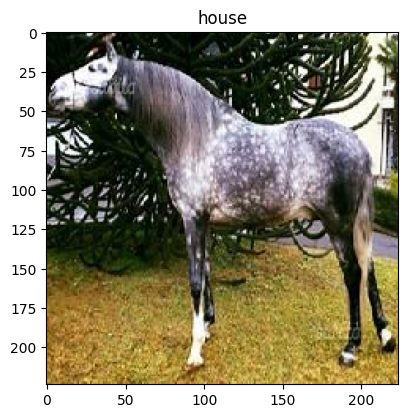

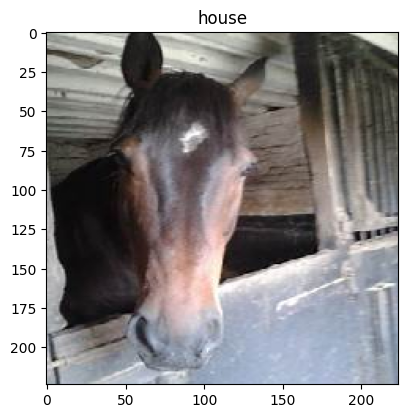

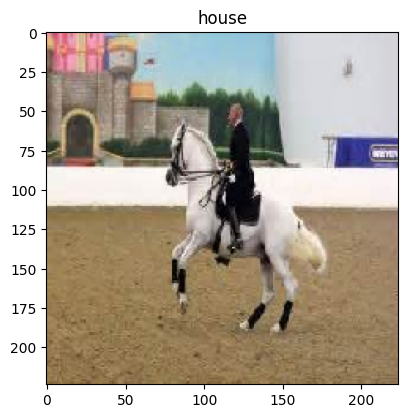

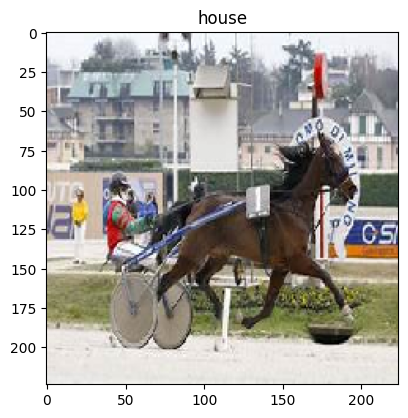

In [207]:
for img, lb in zip(images, labels):
    visual_image([img], [classes[lb]])